<a href="https://colab.research.google.com/github/inahre/GhstCllgs-DreamBooth/blob/main/GhstCllgs_Dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers
!pip install Pillow
!pip install transformers diffusers
#Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes
!pip install huggingface_hub

In [ ]:
#@title Imports

#colab & system
from google.colab import drive
import os
import argparse
import itertools
import math
import random
from contextlib import nullcontext

#image handling & preprocessing
from PIL import Image, ImageOps
import PIL
import numpy as np

#PyTorch & vision
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#Hugging Face Diffusers & Transformers
from diffusers import (
    DiffusionPipeline,
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    PNDMScheduler,
    StableDiffusionSafetyChecker,
    optimization,
    DPMSolverMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from transformers import CLIPTokenizer, CLIPTextModel, CLIPFeatureExtractor

#accelerate
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed

#extras
import bitsandbytes as bnb
from tqdm.auto import tqdm

#Create image grid for visualisation
def image_grid(imgs, rows, cols):
    """
    Arrange a list of PIL images into a grid layout.
    """
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


In [ ]:
#@title Mount Google Drive

drive.mount('/content/gdrive') #to get access to google drive content

Mounted at /content/gdrive


In [ ]:
#@title Path to Dataset

#Define dataset path and target size for preprocessing

image_path = "/content/gdrive/MyDrive/AI_media_project/data"
target_size = (512, 512)  # Required input size for Stable Diffusion

In [ ]:
# @title Output Path

#create path for resized/preprocessed images
output_folder = "/content/gdrive/MyDrive/AI_media_project/resized"

In [ ]:
#@title pre-processing function with Pillow and os

#based on: Pillow documentation https://pillow.readthedocs.io/en/stable/reference/Image.html
# and Python's os module: https://docs.python.org/3/library/os.html

def aspect_ratio_resize(image_path, target_size):
    image = Image.open(image_path)
    width, height = image.size

    #Resize while preserving aspect ratio
    if width > height:
        target_height = int(target_size[0] * (height/width))
        target_width = target_size[0]
    else:
        target_width = int(target_size[1] * (width/height))
        target_height = target_size[1]

    # Resize image
    resized_image = image.resize((target_width, target_height), Image.LANCZOS)

    #Pad to target size
    new_image = Image.new("RGB", target_size)
    x_offset = (target_size[0] - target_width) // 2 #horizontal offset
    y_offset = (target_size[1] - target_height) // 2 #vertical offset
    new_image.paste(resized_image, (x_offset, y_offset))

    return new_image

#loop through and process all images
for image_name in os.listdir(image_path):
    if image_name.lower().endswith((".jpg", ".jpeg", ".png")):
        image_file_path = os.path.join(image_path, image_name)

        #resizing and padding
        resized_image = aspect_ratio_resize(image_file_path, target_size)

        #save the new image
        resized_image.save(os.path.join(output_folder, f"resized_{image_name}"))

MAIN CODE REFERENCE:

https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i

The following code has been adapted and modified from the source listed above. Comments about modifications have been included in the relevant code snippets below.

In [ ]:
#define the instance prompt for DreamBooth fine-tuning

# 'instance_prompt' is a custom token the model will learn to associate with your unique style or subject.
# In this case, "GhstCllgs" refers to a collage-based, film-photography visual style developed by the artist.
instance_prompt = "GhstCllgs"  # Custom identifier (used in training prompts)

# set prior_preservation to False:
# this disables class-based guidance (e.g. "photo of a dog"), which isn't needed here since we're fine-tuning for visual style, not object category.
prior_preservation = False


In [ ]:
# @title Dataset Setup for DreamBooth (Style-Based Training)
#adapted from: https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing
#adjusted for this project — removed class-based logic, focusing on visual style fine-tuning only.

from pathlib import Path
from torchvision import transforms

class GhstCllgs(Dataset):
    def __init__(
        self,
        data_dir,
        instance_prompt,
        tokenizer,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.data_dir = Path(data_dir)
        if not self.data_dir.exists():
            raise ValueError("Instance images root doesn't exist.")

        # Gather image paths
        self.instance_images_path = list(self.data_dir.iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        # Image transforms (resize, crop, normalise)
        self.image_transforms = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if instance_image.mode != "RGB":
            instance_image = instance_image.convert("RGB")

        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
        ).input_ids

        return example


In [ ]:
#@title Model Selection

#define base model for DreamBooth fine-tuning

model_name = "stabilityai/stable-diffusion-xl-base-1.0" #defines pre-trained model used for DreamBooth fine-tuning

In [ ]:
#@title Loading Model Components from SDXL (via diffusers)

#Using Hugging Face's diffusers library with subfolders to extract each module

text_encoder = CLIPTextModel.from_pretrained(
    model_name, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    model_name, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    model_name, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    model_name,
    subfolder="tokenizer",
)

In [ ]:
#@title Training Configuration for DreamBooth
# Adapted from: https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing
# Hyperparameters adjusted based on recommendations from:
# - https://huggingface.co/blog/dreambooth
# - https://towardsdatascience.com/how-to-fine-tune-stable-diffusion-using-dreambooth-dfa6694524ae
# - https://learn.rundiffusion.com/dreambooth-training/
# - https://jefsnacker.medium.com/dreambooth-hyperparameter-guide-d8b7cd264245

from argparse import Namespace

args = Namespace(
    model_name=model_name,
    resolution=vae.sample_size, #should match your model and preprocessed image size (512x512)
    center_crop=False, #already handled during preprocessing
    train_text_encoder=False, #not training the CLIP text encoder
    instance_data_dir="/content/gdrive/MyDrive/Thesis_Project/data/uncaptioned_backdrops/",
    instance_prompt=instance_prompt,

    # Training steps
    max_train_steps=3000, #convention: ~100x number of images (starting with 1500 is fine for testing)
    save_steps=200, #save a checkpoint every 200 steps

    # Batch and memory management
    train_batch_size=4, #larger batch sizes are more relevant for style learning
    gradient_accumulation_steps=2, #4 x 2 = effective batch size of 8
    max_grad_norm=1.0,
    mixed_precision="fp16", #enables faster training with less memory
    gradient_checkpointing=True, #save memory at the cost of slightly slower training
    use_8bit_adam=True, #enable memory-efficient optimizer from bitsandbytes

    # Reproducibility
    seed=3434554,

    # Learning rate strategy
    learning_rate=1e-06,
    lr_scheduler="constant", #no learning rate decay
    lr_warmup_steps=0, #no warm-up (fine-tuning a pretrained model)

    # Prior preservation is disabled since we're focusing on style, not class concepts
    with_prior_preservation=prior_preservation,

    # Output directory for checkpoints — switch depending on run
    output_dir="/content/gdrive/MyDrive/Thesis_Project/uncaptioned_checkpoints"
)

In [ ]:
# @title Training Function for DreamBooth Fine-Tuning
#adapted from Hugging Face Colab by Ina Hrešć
#source: https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24

#training function adapted from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V and modified
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.model_name, subfolder="scheduler")

    train_dataset = GhstCllgs( #replaced with prompt function relevant to current use case
        data_dir=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        #removed if-function for prior preservation

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean") #just defined loss rather than using if-else, as prior preservation not relevant in use case
                accelerator.backward(loss)


                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = DiffusionPipeline.from_pretrained(
                            args.model_name,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = DiffusionPipeline.from_pretrained(
            args.model_name,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run the training job
#adapted from: https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i

import accelerate

#launch training using Accelerate's notebook launcher
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

#clear unused gradients from memory
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad

torch.cuda.empty_cache()

In [ ]:
#@title Inference

#Path to your trained model
model_path = "/content/ghst-cllgs03"  #or from Google Drive if mounted

# Load the pipeline with appropriate dtype and device
pipe = DiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16  #or torch.float32 if you're on CPU
).to("cuda")  #use .to("cpu") if you're not using a GPU

#Optional: set safety checker to None if not needed
pipe.safety_checker = None

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#@title Set up pipeline for image generation

try:
    pipe
except NameError:
    pipe = DiffusionPipeline.from_pretrained(
        args.output_dir,
        scheduler = DPMSolverMultistepScheduler.from_pretrained(args.output_dir, subfolder="scheduler"),
        torch_dtype=torch.float16,
    ).to("cuda")

  0%|          | 0/25 [00:00<?, ?it/s]

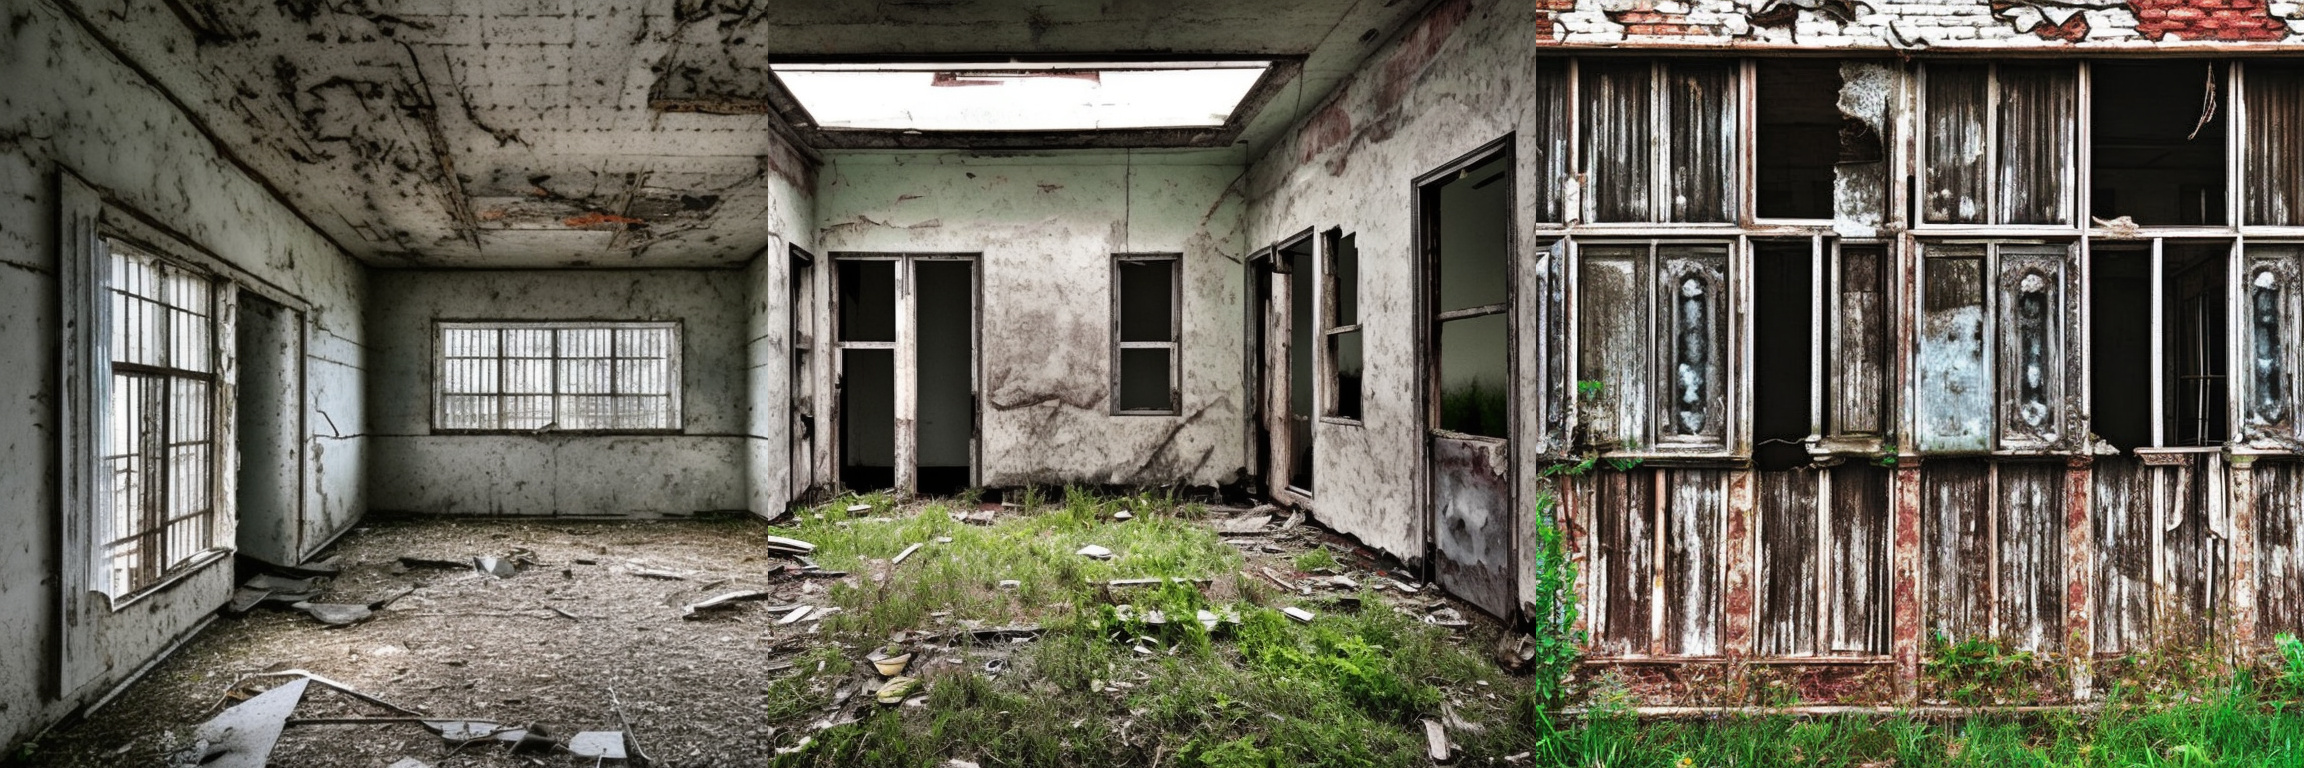

In [ ]:
#@title Run the Stable Diffusion
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "abandoned building in the style of ghstcllgs" #@param {type:"string"}

num_samples = 3 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

sources used throughout coding process:

main sources:

https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i

https://huggingface.co/docs/diffusers/en/index

other sources:

https://pillow.readthedocs.io/en/stable/reference/Image.html

https://huggingface.co/blog/dreambooth (for instructions on hyperparameter fine-tuning)

https://docs.python.org/3/library/os.html

https://huggingface.co/blog/dreambooth

https://towardsdatascience.com/how-to-fine-tune-stable-diffusion-using-dreambooth-dfa6694524ae

https://learn.rundiffusion.com/dreambooth-training/#:~:text=Batch%20size%3A&text=If%20you%20have%20a%20small,should%20be%20kept%20quite%20low

https://github.com/d8ahazard/sd_dreambooth_extension/wiki/Batch-Size

https://jefsnacker.medium.com/dreambooth-hyperparameter-guide-d8b7cd264245

debugging sources:

https://stackoverflow.com/questions/74962932/not-able-to-select-an-option-on-google-colab

https://huggingface.co/ina-hre/ghst-cllgs03?clone=true

*These are all listed in relevant parts throughout the code.

Note: Language models (e.g., Gemini) were used during development to support literature searches, clarify code functions, and assist with debugging.